<a href="https://colab.research.google.com/github/kmayutrisna/SA_IMDB/blob/main/Yelp_Glove_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary library
import pandas as pd

In [2]:
#Get the dataset from gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Display top of data
yelp_train = pd.read_csv("drive/My Drive/data/train_yelp.csv")
yelp_test =pd.read_csv("drive/My Drive/data/test_yelp.csv")

In [4]:
# Get the number of data points in each dataset
num_train_data = len(yelp_train)
num_test_data = len(yelp_test)

In [5]:
print(f"Number of data points in train dataset: {num_train_data}")
print(f"Number of data points in test dataset: {num_test_data}")

Number of data points in train dataset: 560000
Number of data points in test dataset: 38000


In [6]:
# Check for duplicates in the train dataset
train_duplicates = yelp_train[yelp_train.duplicated()]

# Check for duplicates in the test dataset
test_duplicates = yelp_test[yelp_test.duplicated()]

In [7]:
if len(train_duplicates) > 0:
    print("Duplicates found in train dataset:")
    print(train_duplicates)
else:
    print("No duplicates found in train dataset")

if len(test_duplicates) > 0:
    print("Duplicates found in test dataset:")
    print(test_duplicates)
else:
    print("No duplicates found in test dataset")

No duplicates found in train dataset
No duplicates found in test dataset


In [8]:
# Check for rows with missing or empty values in the "label" column
missing_label_rows = yelp_train[yelp_train['label'].isnull() | yelp_train['label'].eq('')]

if not missing_label_rows.empty:
    print("Rows with missing or empty labels found:")
    print(missing_label_rows)
else:
    print("No rows with missing or empty labels found")

No rows with missing or empty labels found


In [9]:
# Check for rows with missing or empty values in the "label" column
missing_label_rows = yelp_test[yelp_test['label'].isnull() | yelp_test['label'].eq('')]

if not missing_label_rows.empty:
    print("Rows with missing or empty labels found:")
    print(missing_label_rows)
else:
    print("No rows with missing or empty labels found")

No rows with missing or empty labels found


In [1]:
# Import necessary library
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, GRU
import re
import string
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

In [2]:
#Get the dataset from gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Display top of data
yelp_train = pd.read_csv("drive/My Drive/data/train_yelp.csv")
yelp_test =pd.read_csv("drive/My Drive/data/test_yelp.csv")

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
# Text preprocessing
from nltk.corpus import stopwords
def preprocess_text(text):

    # Text cleaning
    text = re.sub('[^a-zA-Z]', ' ', text)

    #Single character removal
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)

    #Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)

    # Lowercasing
    text = text.lower()

    # Lowercasing
    text = text.split()

    # Stopword removal
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if not word in stop_words]

    # Join the tokens back to a single string
    text = ' '.join(text)
    return text

In [6]:
# Preprocess the text column
yelp_train['text'] = yelp_train['text'].apply(preprocess_text)
yelp_test['text'] = yelp_test['text'].apply(preprocess_text)

In [7]:
X_train = yelp_train['text'].values
y_train = yelp_train['label'].values
X_test = yelp_test['text'].values  # Change 'data' to 'data_test'
y_test = yelp_test['label'].values  # Change 'data' to 'data_test'

In [8]:
# Tokenize and pad sequences
max_len = 100  # Maximum sequence length
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_train = pad_sequences(sequences_train, maxlen=max_len)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_test = pad_sequences(sequences_test, maxlen=max_len)

In [9]:
# Load GloVe word embeddings
# Replace 'path_to_glove' with the path to your downloaded GloVe embeddings file
embedding_index = {}
with open('drive/My Drive/data/glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefficients = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefficients

# Create word-to-index mapping
word_index = tokenizer.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, 100))  # Assuming you downloaded GloVe with 100-dimensional vectors
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [10]:
# Build the Model
model = Sequential()
model.add(Embedding(num_words, 100, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

# Compile the Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
# Train the Model
history = model.fit(sequences_train, y_train, epochs=5, batch_size=32, validation_data=(sequences_test, y_test))

Epoch 1/5
17500/17500 [==============================] - 383s 22ms/step - loss: 0.2560 - accuracy: 0.8925 - val_loss: 0.2158 - val_accuracy: 0.9116
Epoch 2/5
17500/17500 [==============================] - 379s 22ms/step - loss: 0.2126 - accuracy: 0.9129 - val_loss: 0.2138 - val_accuracy: 0.9135
Epoch 3/5
17500/17500 [==============================] - 380s 22ms/step - loss: 0.1953 - accuracy: 0.9211 - val_loss: 0.2071 - val_accuracy: 0.9159
Epoch 4/5
17500/17500 [==============================] - 380s 22ms/step - loss: 0.1818 - accuracy: 0.9267 - val_loss: 0.2118 - val_accuracy: 0.9153
Epoch 5/5
17500/17500 [==============================] - 380s 22ms/step - loss: 0.1717 - accuracy: 0.9311 - val_loss: 0.2207 - val_accuracy: 0.9127


In [12]:
# Evaluate the Model
y_pred = model.predict(sequences_test)
y_pred = (y_pred > 0.5).astype(int)

1188/1188 [==============================] - 10s 8ms/step


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1*100:.2f}%")

Accuracy: 91.27%
Precision: 93.50%
Recall: 88.71%
F1 Score: 91.04%


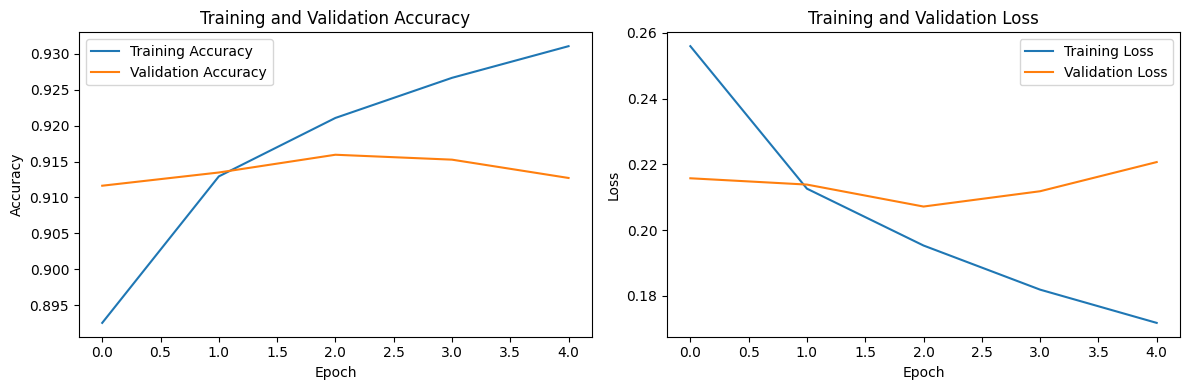

In [14]:
# Plot Training History (Accuracy and Loss)
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()